In [3]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
import numpy as np

# Load the dataset
data = pd.read_csv('english.csv')  # Adjust to your dataset path

# Define Gujarati stopwords

nltk.download('stopwords')
marathi_stopwords = set(stopwords.words('english'))

# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Keep only English alphabet characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

data['cleaned_sentence'] = data['Sentence'].apply(preprocess_text)

# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])

# Handle class imbalance (oversampling minority classes)
sentiment_counts = data['encoded_sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resample the minority class to match the majority
minority_class = data[data['encoded_sentiment'] == min_class]
majority_class = data[data['encoded_sentiment'] != min_class]
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
data_balanced = pd.concat([majority_class, minority_upsampled])

# Split data into training and test sets
X_train, X_test, y_sentiment_train, y_sentiment_test, y_emotion_train, y_emotion_test = train_test_split(
    data_balanced['cleaned_sentence'], data_balanced['encoded_sentiment'], data_balanced['encoded_emotion'], test_size=0.2, random_state=42)

# Tokenize the text data and pad sequences for uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them the same length
max_seq_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        attention_output = tf.matmul(distribution, value)
        return attention_output

# Build the LSTM model with Attention and Bidirectional LSTM
embedding_dim = 128
lstm_units = 64

# Input layer
input_layer = Input(shape=(max_seq_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

# Attention layer
attention_output = AttentionLayer()([lstm_layer, lstm_layer])

# Flatten attention output
flatten_attention = attention_output[:, -1, :]  # Use the final step of attention output

# Shared Dense layer
shared_dense_layer = Dense(64, activation='relu')(flatten_attention)

# Sentiment output
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(shared_dense_layer)

# Emotion output
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(shared_dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[sentiment_output, emotion_output])

# Compile the model with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights_sentiment = compute_class_weight('balanced', classes=np.unique(y_sentiment_train), y=y_sentiment_train)
class_weights_emotion = compute_class_weight('balanced', classes=np.unique(y_emotion_train), y=y_emotion_train)

model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'},
              loss_weights={'sentiment_output': class_weights_sentiment, 'emotion_output': class_weights_emotion})

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 16)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 16, 128)        │        642,816 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 16, 128)        │         98,816 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_1         │ (None, 16, 128)        │              0 │ bidirectional_1[0][0], │
│ (AttentionLayer)          │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ attention_layer_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 9)              │            585 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 750,668 (2.86 MB)

 Trainable params: 750,668 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compile the model without loss_weights
model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy',
                    'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'})


In [6]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for sentiment and emotion separately
sample_weights_sentiment = compute_sample_weight('balanced', y_sentiment_train)
sample_weights_emotion = compute_sample_weight('balanced', y_emotion_train)

# Combine sample weights (average them)
sample_weights_combined = (sample_weights_sentiment + sample_weights_emotion) / 2


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the combined sample weights
history = model.fit(
    X_train_pad,
    {'sentiment_output': y_sentiment_train, 'emotion_output': y_emotion_train},
    epochs=1,  # Train for more epochs, but early stopping will prevent overfitting
    batch_size=128,
    validation_data=(X_test_pad, {'sentiment_output': y_sentiment_test, 'emotion_output': y_emotion_test}),
    callbacks=[early_stopping],
    # Provide single combined sample weights (applied to the entire model)
    sample_weight=sample_weights_combined
)


Epoch 1/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - emotion_output_accuracy: 0.7626 - loss: 0.8552 - sentiment_output_accuracy: 0.9022 - val_emotion_output_accuracy: 0.9731 - val_loss: 0.1004 - val_sentiment_output_accuracy: 0.9914
Epoch 2/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - emotion_output_accuracy: 0.9758 - loss: 0.0904 - sentiment_output_accuracy: 0.9928 - val_emotion_output_accuracy: 0.9801 - val_loss: 0.0708 - val_sentiment_output_accuracy: 0.9943
Epoch 3/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - emotion_output_accuracy: 0.9815 - loss: 0.0663 - sentiment_output_accuracy: 0.9952 - val_emotion_output_accuracy: 0.9804 - val_loss: 0.0668 - val_sentiment_output_accuracy: 0.9947
Epoch 4/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - emotion_output_accuracy: 0.9846 - loss: 0.0562 - sentiment_output_accuracy: 0.9958 - val_emotion_output_accuracy: 0.9830 - val_loss: 0.0572 - val_sentiment_output_accuracy: 0.9952
Epoch 5/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict sentiment and emotion on test data
y_sentiment_pred, y_emotion_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_sentiment_pred_labels = np.argmax(y_sentiment_pred, axis=1)
y_emotion_pred_labels = np.argmax(y_emotion_pred, axis=1)

# Sentiment evaluation metrics
sentiment_accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred_labels)
sentiment_precision = precision_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_recall = recall_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_f1 = f1_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_conf_matrix = confusion_matrix(y_sentiment_test, y_sentiment_pred_labels)

# Emotion evaluation metrics
emotion_accuracy = accuracy_score(y_emotion_test, y_emotion_pred_labels)
emotion_precision = precision_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_recall = recall_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_f1 = f1_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_conf_matrix = confusion_matrix(y_emotion_test, y_emotion_pred_labels)

# Display results
print(f"Sentiment - Accuracy: {sentiment_accuracy}, Precision: {sentiment_precision}, Recall: {sentiment_recall}, F1 Score: {sentiment_f1}")
print(f"Emotion - Accuracy: {emotion_accuracy}, Precision: {emotion_precision}, Recall: {emotion_recall}, F1 Score: {emotion_f1}")
print("Sentiment Confusion Matrix:")
print(sentiment_conf_matrix)
print("Emotion Confusion Matrix:")
print(emotion_conf_matrix)


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Sentiment - Accuracy: 0.9955937224607654, Precision: 0.995615017319685, Recall: 0.9955937224607654, F1 Score: 0.9955981642615493
Emotion - Accuracy: 0.9855811598822493, Precision: 0.985675408862021, Recall: 0.9855811598822493, F1 Score: 0.985604944692086
Sentiment Confusion Matrix:
[[13278     3     1]
 [    1 13209    60]
 [    3   167 26611]]
Emotion Confusion Matrix:
[[4304    0    1    0    1    1    2   37    0]
 [   0 4445    0    0    0    0    1    0    1]
 [  14    0 4366    1    2    1    4   91    1]
 [   0    0    0 4350    0    0    1    1   93]
 [   9    2    3    0 8994   10   37   13    0]
 [   4    0    5    0    6 8819   18   13    0]
 [  39    0    2    1   20    7 8723   56    0]
 [  62    0   23    0    8    7   39 4305    0]
 [   1    0    2  129    0    0    0    0 4258]]


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


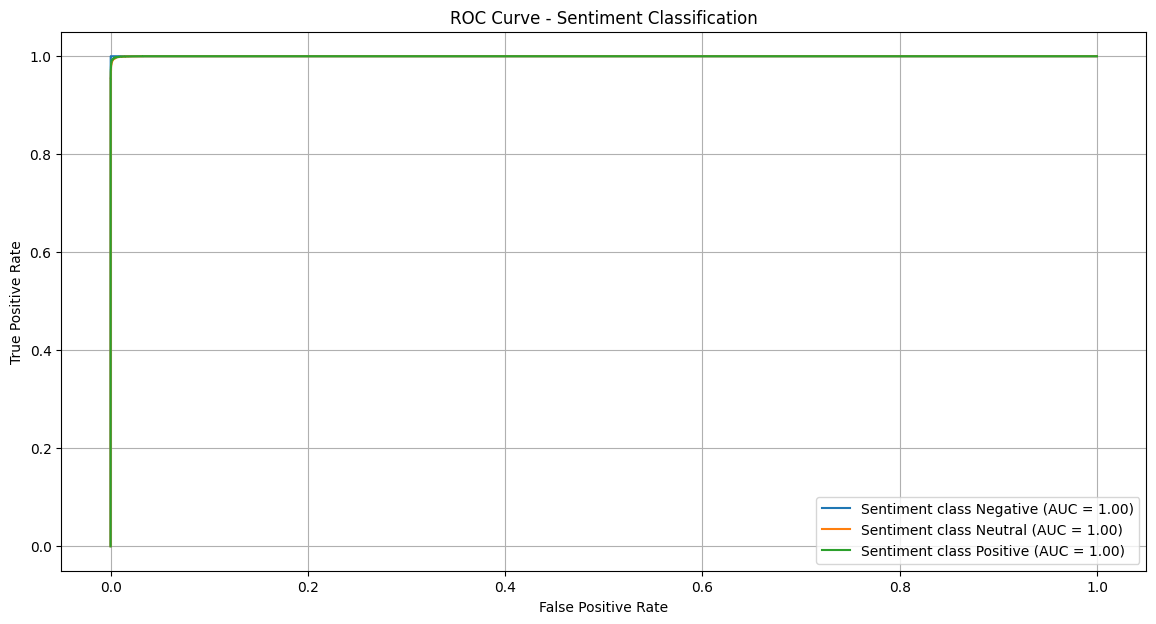

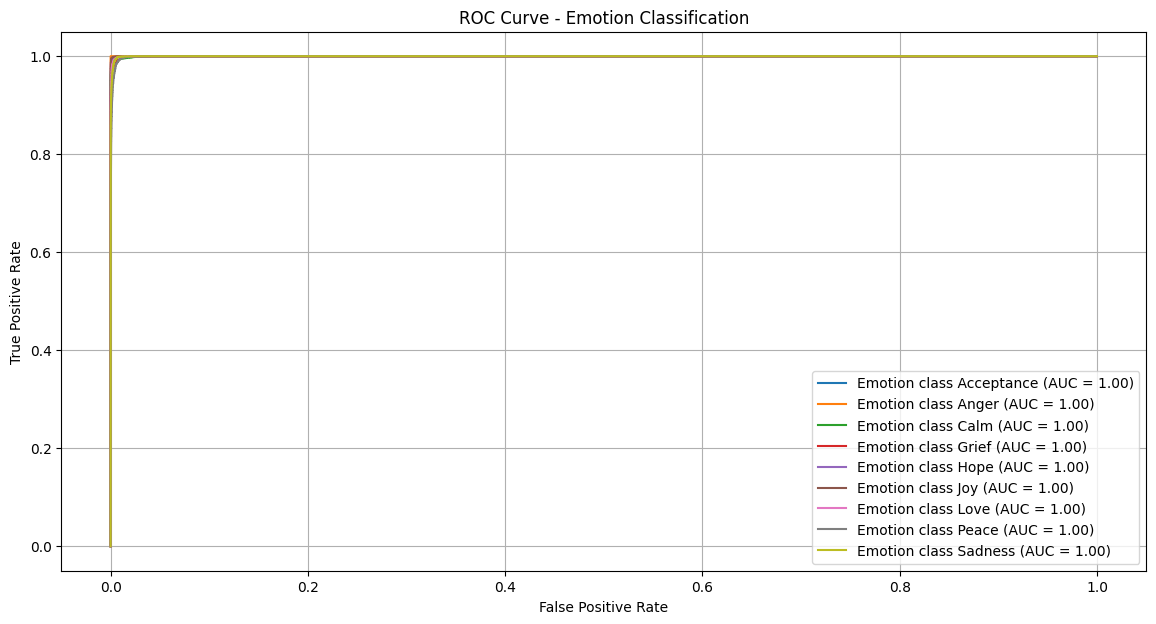

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


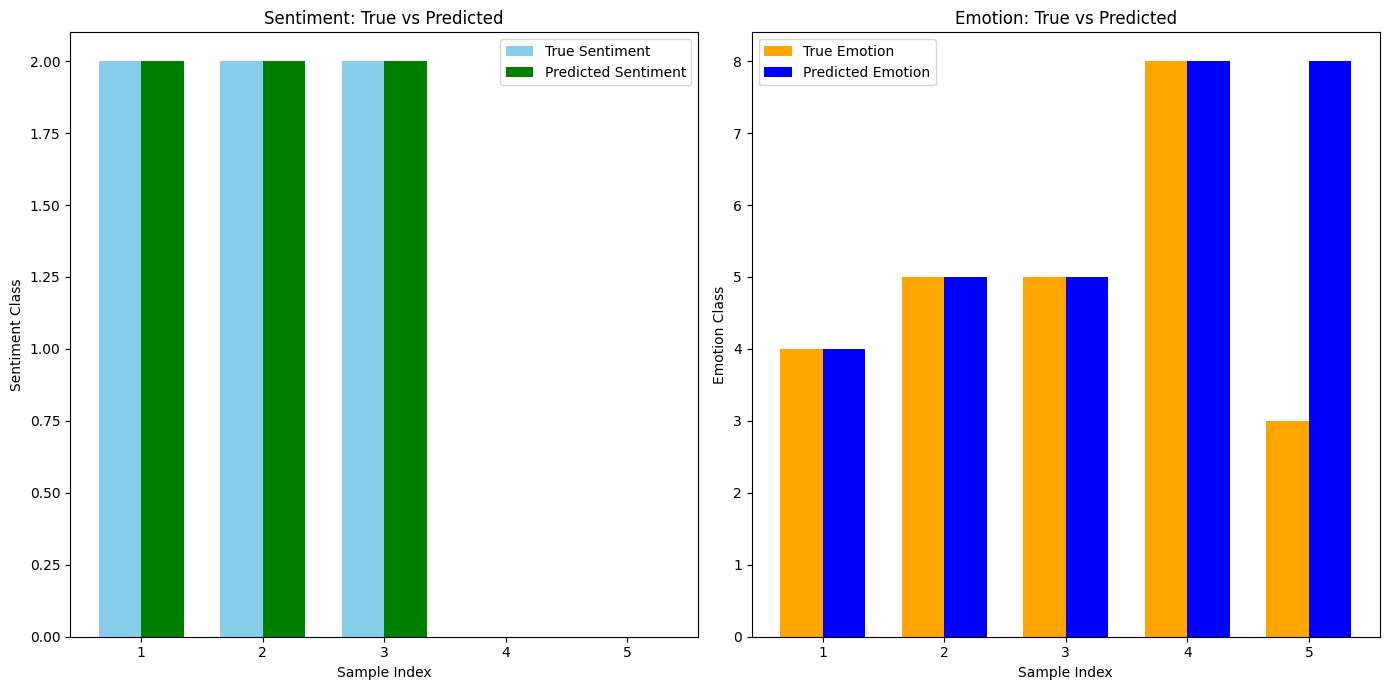

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=5, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Set up the figure
plt.figure(figsize=(14, 7))

# Sentiment Comparison Bar Plot
plt.subplot(1, 2, 1)
x = np.arange(len(sample_sentences))  # Label locations
bar_width = 0.35  # Width of the bars

# Plot bars for true sentiment
plt.bar(x - bar_width / 2, sample_true_sentiments, width=bar_width, color='skyblue', label='True Sentiment')

# Plot bars for predicted sentiment
plt.bar(x + bar_width / 2, sample_sentiment_pred_labels, width=bar_width, color='green', label='Predicted Sentiment')

# Label the plot
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Comparison Bar Plot
plt.subplot(1, 2, 2)

# Plot bars for true emotion
plt.bar(x - bar_width / 2, sample_true_emotions, width=bar_width, color='orange', label='True Emotion')

# Plot bars for predicted emotion
plt.bar(x + bar_width / 2, sample_emotion_pred_labels, width=bar_width, color='blue', label='Predicted Emotion')

# Label the plot
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


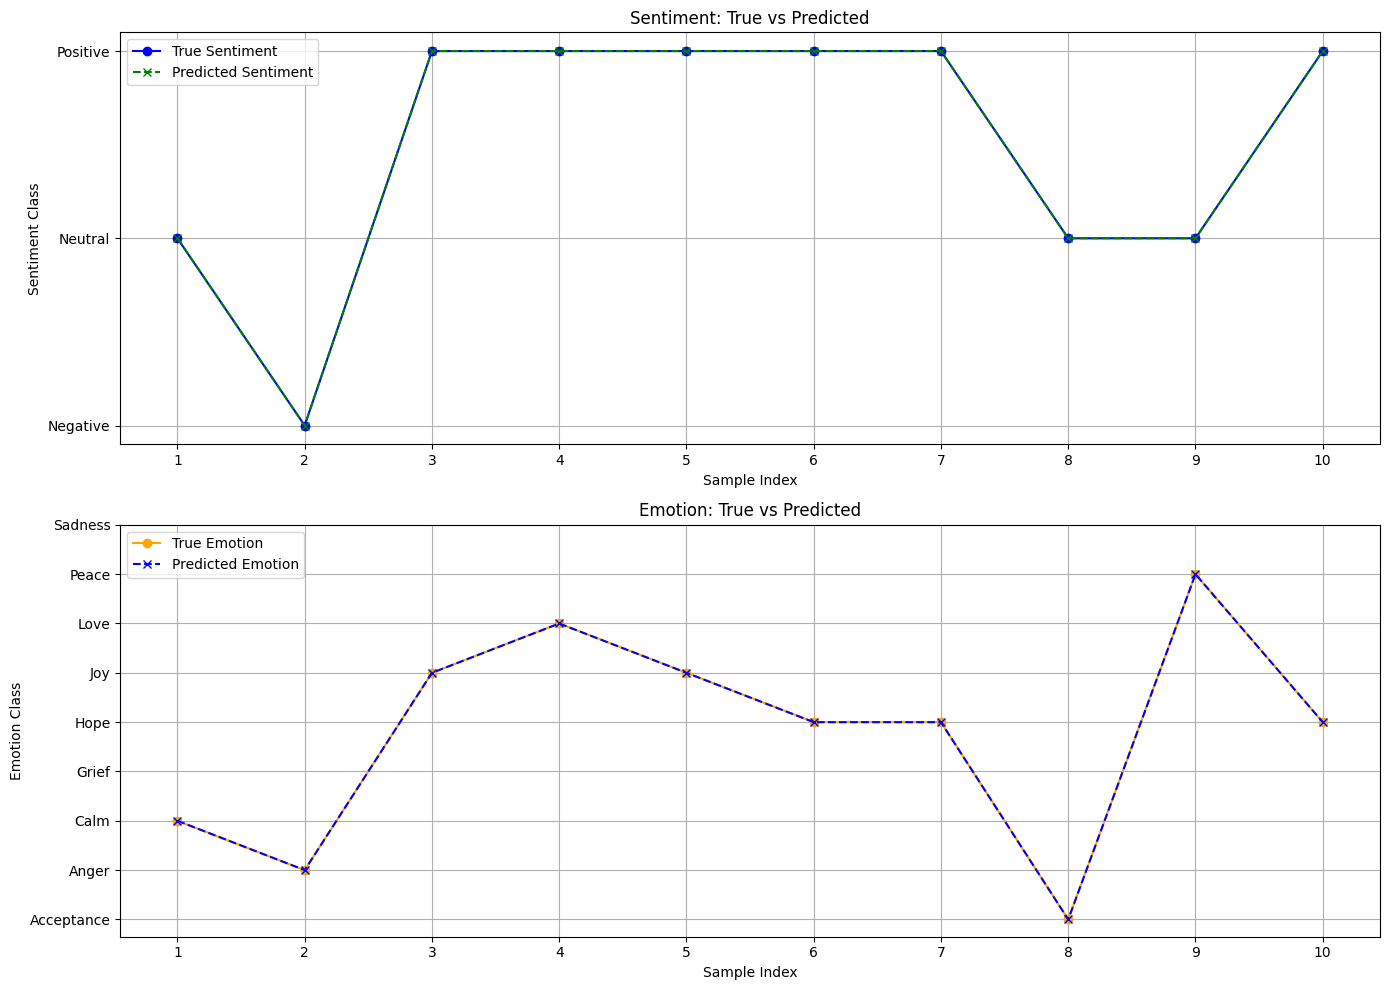

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=10, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Get all possible sentiment and emotion labels
sentiment_classes = sentiment_encoder.classes_  # All possible sentiment labels
emotion_classes = emotion_encoder.classes_  # All possible emotion labels

# Set up the line graph figure
plt.figure(figsize=(14, 10))

# Sentiment Plot: True vs Predicted
plt.subplot(2, 1, 1)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_sentiments, marker='o', linestyle='-', color='blue', label='True Sentiment')
plt.plot(range(1, len(sample_sentences) + 1), sample_sentiment_pred_labels, marker='x', linestyle='--', color='green', label='Predicted Sentiment')
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(sentiment_classes)), labels=sentiment_classes)  # Show all sentiment classes on y-axis
plt.legend()
plt.grid(True)

# Emotion Plot: True vs Predicted
plt.subplot(2, 1, 2)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_emotions, marker='o', linestyle='-', color='orange', label='True Emotion')
plt.plot(range(1, len(sample_sentences) + 1), sample_emotion_pred_labels, marker='x', linestyle='--', color='blue', label='Predicted Emotion')
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(emotion_classes)), labels=emotion_classes)  # Show all emotion classes on y-axis
plt.legend()
plt.grid(True)

# Adjust the layout and display the graph
plt.tight_layout()
plt.show()


In [12]:
# Define custom Gujarati sentences for testing
custom_sentences = ["In your laughter I find my heart melody dancing through every shared moment",
"Like sunbeams breaking clouds your smile ignites warmth filling the air with light",
"Lost in echoes of absence I wander shadows where fading memories linger dimly",
"Each tear falls like raindrops on earth nurturing wounds of aching hearts",
"In quiet dawn I breathe deeply embracing life ebb letting go completely"



]

# English translations of the custom sentences
english_translations = [" ",
" ",
" ",
" ",
" "


]

# Preprocess and tokenize the custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
custom_sentiment_pred, custom_emotion_pred = model.predict(custom_padded_sequences)

# Convert predictions to class labels
custom_sentiment_pred_labels = np.argmax(custom_sentiment_pred, axis=1)
custom_emotion_pred_labels = np.argmax(custom_emotion_pred, axis=1)

# Get the label names from encoders
predicted_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_pred_labels)
predicted_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_pred_labels)

# Display the results for each sentence
for i, sentence in enumerate(custom_sentences):
    print(f"Sentence (Gujarati): {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {predicted_sentiment_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotion_labels[i]}")
    print("----------------------------------------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentence (Gujarati): In your laughter I find my heart melody dancing through every shared moment
English Translation:  
Predicted Sentiment: Positive
Predicted Emotion: Joy
----------------------------------------------------
Sentence (Gujarati): Like sunbeams breaking clouds your smile ignites warmth filling the air with light
English Translation:  
Predicted Sentiment: Positive
Predicted Emotion: Joy
----------------------------------------------------
Sentence (Gujarati): Lost in echoes of absence I wander shadows where fading memories linger dimly
English Translation:  
Predicted Sentiment: Negative
Predicted Emotion: Grief
----------------------------------------------------
Sentence (Gujarati): Each tear falls like raindrops on earth nurturing wounds of aching hearts
English Translation:  
Predicted Sentiment: Negative
Predicted Emotion: Sadness
----------------------------------------------------
Sentence (Gujarati): In quiet dawn I breathe 